In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
from PIL import Image

import sys
import os

# Get path to the parent directory (i.e., project/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from mtt import environment as env

from baseline_src.dataloaders import PrecondDataset

from baseline_src.models import DirectGumbelSymbolEncoder
from baseline_src.models import DirectSymbolToImageDecoder
from baseline_src.models import SymbolicAutoencoder

from baseline_src.trainers import SymbolicTrainer
from baseline_src.utils import visualize_gumbel_reconstructions

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Clone weights into checkpoint folder

import subprocess

# Define repo URL and target directory
repo_url = "https://huggingface.co/anonymoussifaka/mathtakestwo"
target_dir = "checkpoints"

# Run git clone command
try:
    subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    print(f"✅ Repo successfully cloned into ./{target_dir}")
except subprocess.CalledProcessError as e:
    print(f"❌ Failed to clone repo: {e}")

Cloning into 'checkpoints'...


✅ Repo successfully cloned into ./checkpoints


### Set up and pre-train baseline symbolic encoder

In [4]:
generator = env.ExampleGenerator(mode='precond')

# ----- Dataset Setup -----

train_dataset = PrecondDataset(generator, num_samples=50000, mode='img_train')
val_dataset   = PrecondDataset(generator, num_samples=50000, mode='img_val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

# ----- Initialize Symbolic Models -----

symbol_len = 8
vocab_size = 8
image_shape = (1, 47, 41)

sender = DirectGumbelSymbolEncoder(
    in_channels=1,
    hidden_dim=64,
    num_symbols=vocab_size,
    symbol_length=symbol_len,
    temperature=1.0
).to(device)

receiver = DirectSymbolToImageDecoder(
    num_symbols=vocab_size,
    symbol_length=symbol_len,
    embed_dim=64,
    output_shape=image_shape
).to(device)

config = {
    'device': 'cuda',
    'patience': 10,
    'checkpoint_path': 'checkpoints/best_symbolic_gumbel.pth'
}

In [3]:
# ----- Training Loop -----

trainer = SymbolicTrainer(
    sender=sender,
    receiver=receiver,
    optimizer=torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=1e-3),
    loss_fn=nn.MSELoss(),
    dataloader_train=train_loader,
    dataloader_val=val_loader,
    config=config
)

trainer.train(num_epochs=200)

Epoch 1/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 224.56it/s, loss=0.0144]


[Epoch 1] Train Loss: 0.019662 | Val Loss: 0.015063
✅ Saved new best model at epoch 1


Epoch 2/200 [ Val ]: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 298.79it/s, loss=0.013]


[Epoch 2] Train Loss: 0.015201 | Val Loss: 0.014398
✅ Saved new best model at epoch 2


Epoch 3/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 231.48it/s, loss=0.0125]


[Epoch 3] Train Loss: 0.014407 | Val Loss: 0.013717
✅ Saved new best model at epoch 3


Epoch 4/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 231.92it/s, loss=0.0126]


[Epoch 4] Train Loss: 0.014027 | Val Loss: 0.013193
✅ Saved new best model at epoch 4


Epoch 5/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 297.27it/s, loss=0.0139]


[Epoch 5] Train Loss: 0.013399 | Val Loss: 0.013634
⚠️ No improvement. Patience: 1/10


Epoch 6/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 241.94it/s, loss=0.0144]


[Epoch 6] Train Loss: 0.012785 | Val Loss: 0.014260
⚠️ No improvement. Patience: 2/10


Epoch 7/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 278.44it/s, loss=0.0147]


[Epoch 7] Train Loss: 0.012172 | Val Loss: 0.014691
⚠️ No improvement. Patience: 3/10


Epoch 8/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 333.03it/s, loss=0.0159]


[Epoch 8] Train Loss: 0.011820 | Val Loss: 0.014595
⚠️ No improvement. Patience: 4/10


Epoch 9/200 [ Val ]: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 212.00it/s, loss=0.0173]


[Epoch 9] Train Loss: 0.011583 | Val Loss: 0.014705
⚠️ No improvement. Patience: 5/10


Epoch 10/200 [ Val ]: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 261.31it/s, loss=0.0158]


[Epoch 10] Train Loss: 0.011190 | Val Loss: 0.013747
⚠️ No improvement. Patience: 6/10


Epoch 11/200 [ Val ]: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 267.48it/s, loss=0.0168]


[Epoch 11] Train Loss: 0.011013 | Val Loss: 0.014311
⚠️ No improvement. Patience: 7/10


Epoch 12/200 [ Val ]: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 223.71it/s, loss=0.0134]


[Epoch 12] Train Loss: 0.010879 | Val Loss: 0.014281
⚠️ No improvement. Patience: 8/10


Epoch 13/200 [ Val ]: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 246.05it/s, loss=0.0168]


[Epoch 13] Train Loss: 0.010752 | Val Loss: 0.014621
⚠️ No improvement. Patience: 9/10


Epoch 14/200 [ Val ]: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 280.19it/s, loss=0.0131]

[Epoch 14] Train Loss: 0.010563 | Val Loss: 0.014105
⚠️ No improvement. Patience: 10/10
🛑 Early stopping triggered at epoch 14 (best was epoch 4)


In [5]:
checkpoint = torch.load('checkpoints/best_symbolic_gumbel.pth', map_location=config['device'])

sender.load_state_dict(checkpoint['sender_state'])
receiver.load_state_dict(checkpoint['receiver_state'])
# Optional: optimizer.load_state_dict(checkpoint['optimizer_state'])

print(f"✅ Loaded models from epoch {checkpoint['epoch']}")

✅ Loaded models from epoch 3


[Image 1] Symbolic language: z0 z2 z2 z2 z2 z2 z2 z2
[Image 2] Symbolic language: z6 z6 z6 z7 z2 z2 z2 z2
[Image 3] Symbolic language: z4 z4 z4 z4 z2 z2 z2 z2
[Image 4] Symbolic language: z7 z7 z7 z4 z2 z2 z2 z2
[Image 5] Symbolic language: z4 z4 z4 z2 z2 z2 z2 z2


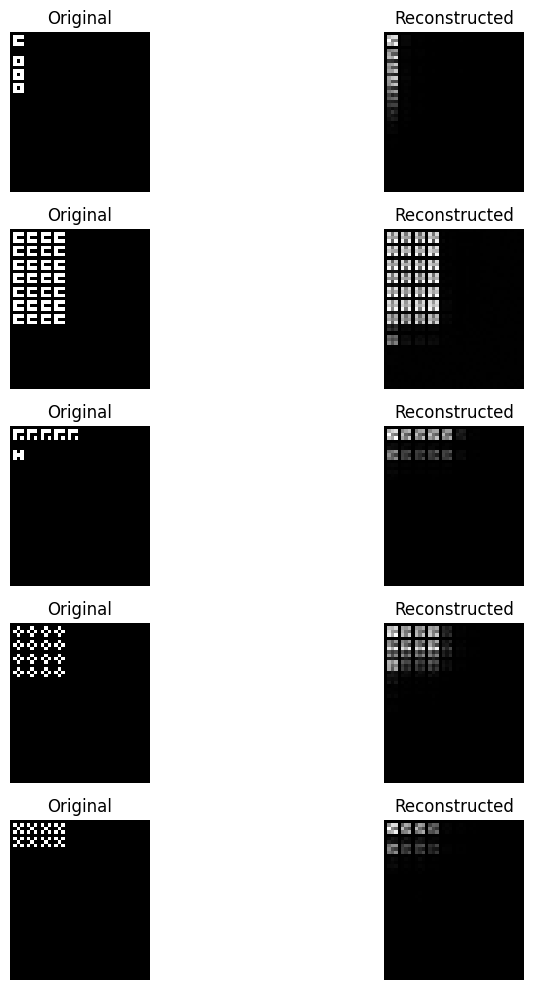

In [6]:
# Visualize reconstructions

visualize_gumbel_reconstructions(sender, receiver, val_loader, device=device, num_examples=5)

### Set up and train  similarity / answer model

In [7]:
from baseline_src.models import SimilarityModel
from baseline_src.trainers import QnATrainer

symbolic_model_set = [sender,
                      receiver]

# --- Freeze or unfreeze parts of the model as needed add params to list ---

#### RESULTS ARE DERIVED FOR FROZEN AND UNFROZEN SYMBOLIC MODELS ####

symbolic_model_params = []

for model in symbolic_model_set:
    params = model.parameters()
    for param in params:
        param.requires_grad = True # False  # or False if you want to freeze
    
    symbolic_model_params += list(params)

# ----- Initialize Answer / Similarity Model -----

answer_model = SimilarityModel(latent_dim=128).to(device)

#answer_optimizer = optim.Adam(answer_model.parameters(), lr=1e-3)
answer_optimizer = optim.Adam(list(answer_model.parameters()) + symbolic_model_params, lr=1e-3)

criterion = nn.CrossEntropyLoss()

# ----- Setup Datasets and Dataloaders ------

train_dataset = PrecondDataset(generator, num_samples=10000, mode='qna_train')
val_dataset = PrecondDataset(generator, mode='qna_val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

symbolic_model = SymbolicAutoencoder(sender, receiver)

config = {
    "num_epochs": 50,
    "patience": 10,
    "save_path": "checkpoints/best_similarity_model_unfrozen_gumbel.pth", # best_similarity_model_unfrozen_gumbel.pth
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [9]:
# ---- Run Training Loop -----

trainer = QnATrainer(
    answer_model=answer_model,
    symbolic_model=symbolic_model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    criterion=criterion,
    optimizer=answer_optimizer,
    config=config
)

trainer.train()


Train Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.74it/s]



Epoch 1: Train Loss=333.4854, Train Acc=0.6048 | Val Loss=16.6146, Val Acc=0.6120


Train Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.63it/s]



Epoch 2: Train Loss=321.9392, Train Acc=0.6355 | Val Loss=16.2317, Val Acc=0.6380


Train Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 21.94it/s]



Epoch 3: Train Loss=316.0043, Train Acc=0.6544 | Val Loss=16.2116, Val Acc=0.6180


Train Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.03it/s]



Epoch 4: Train Loss=313.3303, Train Acc=0.6435 | Val Loss=15.7397, Val Acc=0.6340


Train Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.10it/s]



Epoch 5: Train Loss=312.0166, Train Acc=0.6453 | Val Loss=15.9499, Val Acc=0.6700


Train Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 21.88it/s]



Epoch 6: Train Loss=308.6198, Train Acc=0.6472 | Val Loss=15.8292, Val Acc=0.6440


Train Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.09it/s]



Epoch 7: Train Loss=306.4719, Train Acc=0.6547 | Val Loss=15.2728, Val Acc=0.6960


Train Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.11it/s]



Epoch 8: Train Loss=305.2333, Train Acc=0.6678 | Val Loss=15.6242, Val Acc=0.6560


Train Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.24it/s]



Epoch 9: Train Loss=304.9488, Train Acc=0.6660 | Val Loss=15.5353, Val Acc=0.6500


Train Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.37it/s]



Epoch 10: Train Loss=304.0404, Train Acc=0.6632 | Val Loss=15.3599, Val Acc=0.6480


Train Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.12it/s]



Epoch 11: Train Loss=302.2362, Train Acc=0.6657 | Val Loss=15.2730, Val Acc=0.6820


Train Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.70it/s]



Epoch 12: Train Loss=301.6554, Train Acc=0.6664 | Val Loss=15.3197, Val Acc=0.6840


Train Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.21it/s]



Epoch 13: Train Loss=302.9672, Train Acc=0.6705 | Val Loss=15.0929, Val Acc=0.6920


Train Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.36it/s]



Epoch 14: Train Loss=301.4699, Train Acc=0.6687 | Val Loss=15.2313, Val Acc=0.6980


Train Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.57it/s]



Epoch 15: Train Loss=302.1050, Train Acc=0.6709 | Val Loss=15.2876, Val Acc=0.7220


Train Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.33it/s]



Epoch 16: Train Loss=301.2502, Train Acc=0.6695 | Val Loss=15.2704, Val Acc=0.6840


Train Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.24it/s]



Epoch 17: Train Loss=299.7895, Train Acc=0.6795 | Val Loss=15.3905, Val Acc=0.6440


Train Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.29it/s]



Epoch 18: Train Loss=298.7478, Train Acc=0.6841 | Val Loss=15.3333, Val Acc=0.7120


Train Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.23it/s]



Epoch 19: Train Loss=298.5244, Train Acc=0.6807 | Val Loss=15.6355, Val Acc=0.6260


Train Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.64it/s]



Epoch 20: Train Loss=298.1938, Train Acc=0.6796 | Val Loss=14.8869, Val Acc=0.7280


Train Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.41it/s]



Epoch 21: Train Loss=298.3912, Train Acc=0.6809 | Val Loss=15.1417, Val Acc=0.7040


Train Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.15it/s]



Epoch 22: Train Loss=297.4709, Train Acc=0.6801 | Val Loss=14.9338, Val Acc=0.6980


Train Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.48it/s]



Epoch 23: Train Loss=297.8557, Train Acc=0.6882 | Val Loss=15.2372, Val Acc=0.6720


Train Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.78it/s]



Epoch 24: Train Loss=296.7891, Train Acc=0.6882 | Val Loss=15.2625, Val Acc=0.6700


Train Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.28it/s]



Epoch 25: Train Loss=296.3396, Train Acc=0.6892 | Val Loss=15.0420, Val Acc=0.6680


Train Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.31it/s]



Epoch 26: Train Loss=299.0894, Train Acc=0.6810 | Val Loss=15.2680, Val Acc=0.7000


Train Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.38it/s]



Epoch 27: Train Loss=296.0879, Train Acc=0.6841 | Val Loss=15.1269, Val Acc=0.6840


Train Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.49it/s]



Epoch 28: Train Loss=295.2673, Train Acc=0.6952 | Val Loss=15.1976, Val Acc=0.6460


Train Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.50it/s]



Epoch 29: Train Loss=294.9725, Train Acc=0.6936 | Val Loss=14.8852, Val Acc=0.7020


Train Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:13<00:00, 22.37it/s]



Epoch 30: Train Loss=296.4875, Train Acc=0.6857 | Val Loss=15.5038, Val Acc=0.6780
🛑 Early stopping triggered.
✅ Best model weights restored.


In [8]:
import random

# Set random seed for practice / Test evaluation

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
from baseline_src.dataloaders import PracTestDataset

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

answer_model = SimilarityModel(latent_dim=128).to(device)
answer_optimizer = optim.Adam(answer_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

answer_model.load_state_dict(torch.load("checkpoints/best_similarity_model_frozen_gumbel.pth")) # best_similarity_model_unfrozen_gumbel.pth
answer_model.train()

# --- Practice loop for qna model using inputs from symbolic_model  ---

# --- Practice Question Dataloader ---

quiz_generator = quiz_generator = env.QuizGeneratorML()
prac_dataset = PracTestDataset(quiz_generator=quiz_generator, mode='qna_prac')
practice_loader = DataLoader(prac_dataset, batch_size=2)

# Codes for in vs out of distribution testing

prac_logger = env.EvalLogger('precond', 'practice') # input precond -> practice, or practice -> test
prac_loss = 0

for img, questions, answer, program, options in tqdm(practice_loader, desc=f"Practice Run"):
    
    img, questions, answer = img.to(device), questions.to(device), answer.to(device)
    img_recon, symbols = symbolic_model(img, hard=True)
    
    logits = answer_model(img_recon, questions)
    loss = criterion(logits, answer)

    answer_optimizer.zero_grad()
    loss.backward()
    answer_optimizer.step()

    prac_loss += loss.item()
    prediction = logits.argmax(dim=1)
    
    # Pass batch inputs into qna tester
    prac_logger.test_qna(answer.cpu(), prediction.cpu(), program, options)


results_dict= prac_logger.return_results()
torch.save(answer_model.state_dict(), "checkpoints/test_similarity_model_unfrozen_gumbel.pth") # test_similarity_model_unfrozen_gumbel.pth
    
print(f"Practice Loss={prac_loss:.4f}, Practice Acc={results_dict['accuracy']:.4f}")

print('Number logged: ', [k + ':' + str(v)[:4] for k,v in results_dict['logging_dict'].items()])
print('Number correct: ', [k + ':' + str(v)[:4] for k,v in results_dict['correct_dict'].items()])
print('Accuracy: ', [k + ':' + str(v)[:4] for k,v in results_dict['accuracy_dict'].items()])


Practice Run: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 217.59it/s]

Practice Loss=51.5366, Practice Acc=0.6000
Number logged:  ['ood_symbol_question:47', 'ood_number_question:31', 'ood_both_question:16', 'ood_symbol_answer:57', 'ood_number_answer:41', 'ood_both_answer:20']
Number correct:  ['ood_symbol_question:25', 'ood_number_question:21', 'ood_both_question:10', 'ood_symbol_answer:33', 'ood_number_answer:28', 'ood_both_answer:13']
Accuracy:  ['ood_symbol_question:0.53', 'ood_number_question:0.67', 'ood_both_question:0.62', 'ood_symbol_answer:0.57', 'ood_number_answer:0.68', 'ood_both_answer:0.65']


Dictionary saved to results/symbolic_autoencoder_frozen_results_practice.pkl
[Image 1] | Program: B12*12 | Questions: ['B12*12', 'B11*12', 'AC+AB', 'B12*2']
[Image 1] Bottleneck symbols:     btensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')



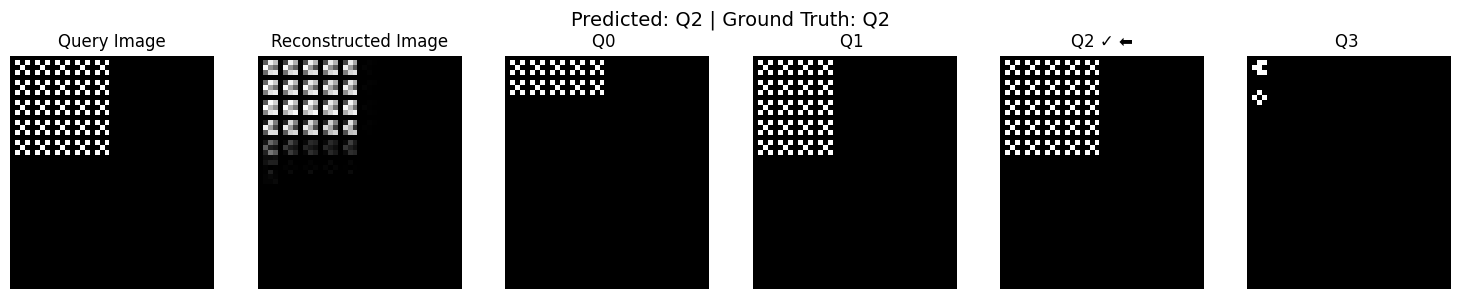

In [11]:
from baseline_src.utils import visualize_qna_prediction
import pickle 

# Path to save the pickle file
file_path = os.path.join('results', 'symbolic_autoencoder_frozen_results_practice.pkl')

# Save the dictionary
with open(file_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f"Dictionary saved to {file_path}")

visualize_qna_prediction(answer_model, symbolic_model, prac_dataset, device=device)

In [13]:
# --- Test loop for qna model using inputs from symbolic_model ---
# --- Test Question Dataloader ---

quiz_generator = quiz_generator = env.QuizGeneratorML()
test_dataset = PracTestDataset(quiz_generator=quiz_generator, mode='qna_test')

test_loader = DataLoader(test_dataset, batch_size=1)

answer_model.eval()
test_correct = 0

practice_codes = set(env.ShapeLibrary(mode='practice').shape_codes)
practice_numbers = set(env.NumberLibrary(mode='practice').numbers)

test_codes = set(env.ShapeLibrary(mode='test').shape_codes)
new_test_codes = list(test_codes.difference(practice_codes))

test_numbers = set(env.NumberLibrary(mode='test').numbers)
new_test_numbers = list(test_numbers.difference(practice_numbers))

test_logger = env.EvalLogger('practice', 'test') # input precond -> practice, or practice -> test

with torch.no_grad():

    for img, questions, answer, program, options in tqdm(test_loader, desc=f"Testing..."):

        img, questions, answer = img.to(device), questions.to(device), answer.to(device)
        img_recon, symbols = symbolic_model(img, hard=True)
        
        logits = answer_model(img_recon, questions)
        prediction = logits.argmax(dim=1)
        
        test_logger.test_qna(answer.cpu(), prediction.cpu(), program, options)


results_dict = test_logger.return_results()
    
print(f"Test Acc={results_dict['accuracy']:.4f}")

print('Number logged: ', [k + ':' + str(v)[:4] for k,v in results_dict['logging_dict'].items()])
print('Number correct: ', [k + ':' + str(v)[:4] for k,v in results_dict['correct_dict'].items()])
print('Accuracy: ', [k + ':' + str(v)[:4] for k,v in results_dict['accuracy_dict'].items()])


Testing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 546.98it/s]

Test Acc=0.6000
Number logged:  ['ood_symbol_question:45', 'ood_number_question:26', 'ood_both_question:13', 'ood_symbol_answer:64', 'ood_number_answer:34', 'ood_both_answer:22']
Number correct:  ['ood_symbol_question:23', 'ood_number_question:14', 'ood_both_question:4', 'ood_symbol_answer:35', 'ood_number_answer:19', 'ood_both_answer:8']
Accuracy:  ['ood_symbol_question:0.51', 'ood_number_question:0.53', 'ood_both_question:0.30', 'ood_symbol_answer:0.54', 'ood_number_answer:0.55', 'ood_both_answer:0.36']


[Image 1] | Program: AC+BA12 | Questions: ['AC+BA12', 'AC+BA11', 'AC+BA2', 'CA']
[Image 1] Bottleneck symbols:     btensor([[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')



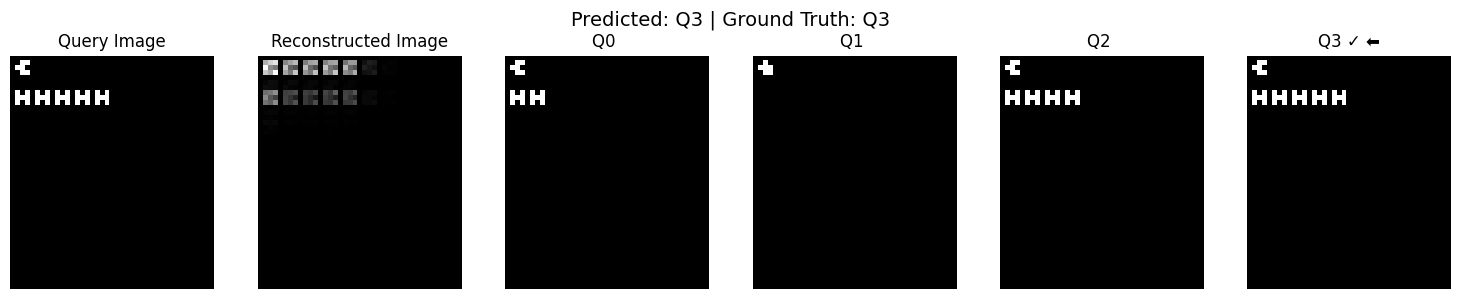

[Image 1] | Program: B10*10+A | Questions: ['B10*10+A', 'AB10*10', 'A*2+AC10', 'B20*10+A']
[Image 1] Bottleneck symbols:     btensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')



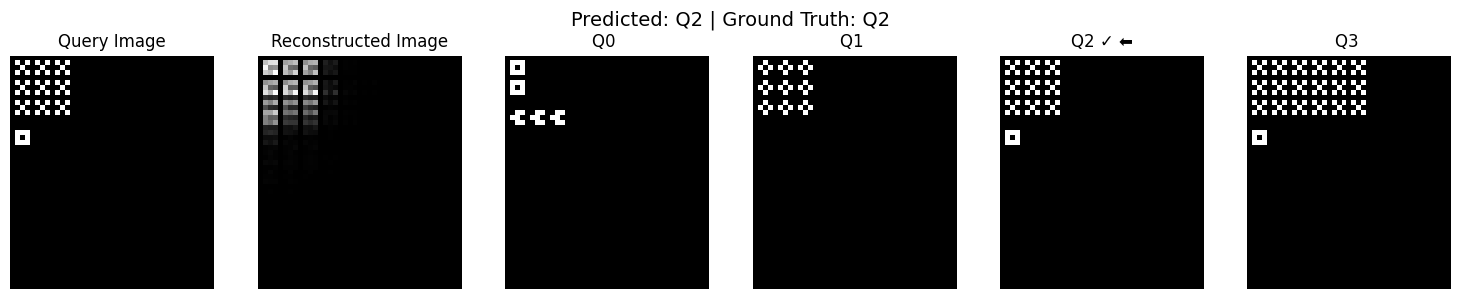

[Image 1] | Program: B*12 | Questions: ['B*12', 'AC*2', 'C*2', 'A10*22']
[Image 1] Bottleneck symbols:     btensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')



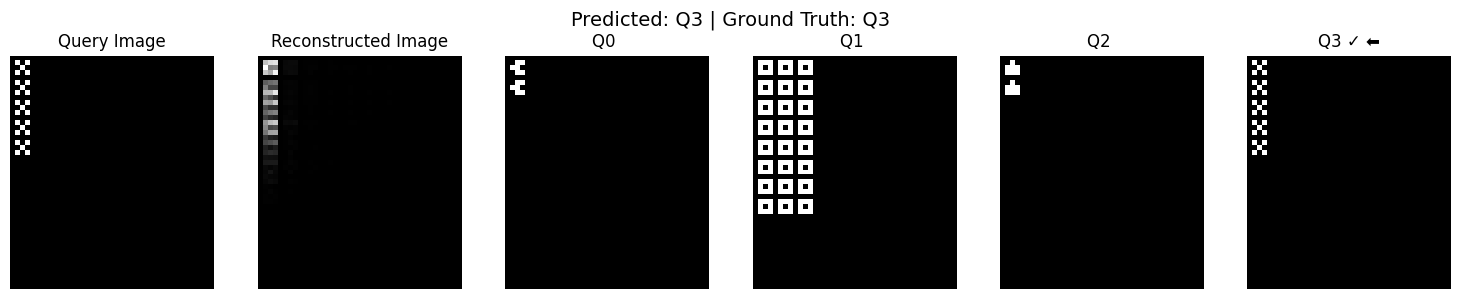

In [14]:

for i in range(3):
    visualize_qna_prediction(answer_model, symbolic_model, test_dataset, device=device)

In [30]:
import pickle 

# Path to save the pickle file
file_path = os.path.join('results', 'symbolic_autoencoder_frozen_results_test.pkl')

# Save the dictionary
with open(file_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f"Dictionary saved to {file_path}")

Dictionary saved to results/symbolic_autoencoder_frozen_results_test.pkl
